In [116]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    
# posterior samples
import numpy as np
from scipy.stats import gaussian_kde

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns
import warnings
warnings.simplefilter('ignore')
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

In [117]:
# Data
# cpi data
data_cpi = pd.read_csv("../data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change(4) * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Number of Firm data
data_HHI_annual = pd.read_csv("../data/hhi_from_Gustavo_2019.csv")
data_HHI_annual["HHI"] = data_HHI_annual["Value"] * 0.0001
data_HHI_annual['year'] = pd.to_datetime(data_HHI_annual['Year'], format='%Y') + pd.offsets.YearBegin(0)
data_HHI_annual = data_HHI_annual.set_index('year')
data_HHI = data_HHI_annual.resample('QS').asfreq()
data_HHI['HHI'] = data_HHI['HHI'].interpolate(method='linear')
data_HHI = data_HHI.reset_index()
data_HHI['DATE'] = pd.to_datetime(data_HHI['year'])
data_HHI = data_HHI[["DATE", "HHI"]]
data_HHI["N"] = 1/data_HHI["HHI"]

# Markup data
data_markup = pd.read_excel("../data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# De-trended Markup data
data_markup_BN = pd.read_csv("../data/BN_markup_inv.csv")
data_markup_BN['markup_BN_inv'] = data_markup_BN["cycle"] 
data_markup_BN['DATE'] = data_markup_BN["date"]
data_markup_BN = data_markup_BN[["DATE","markup_BN_inv"]].dropna()
data_markup_BN['DATE'] = pd.to_datetime(data_markup_BN['DATE'])

# unemployment gap
# NROU
data_nairu = pd.read_csv("../data/NROU.csv")
data_nairu["DATE"] = pd.to_datetime(data_nairu["observation_date"])
# unemployment
data_unemp = pd.read_csv("../data/UNRATENSA.csv")
data_unemp["DATE"] = pd.to_datetime(data_unemp["observation_date"])
data_unempgap = pd.merge(data_nairu, data_unemp, on="DATE", how="outer")
data_unempgap['unemp_gap'] = data_unempgap['NROU'] - data_unempgap['UNRATENSA']
data_unempgap = data_unempgap.dropna()
data_unempgap = data_unempgap[["DATE", "unemp_gap"]]

# output gap data
data_output = pd.read_csv("../data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])

# inflation expectation data
data_Epi = pd.read_csv("../data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_HHI, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_markup_BN, on="DATE", how="outer")
data = pd.merge(data, data_unempgap, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data['N_prev'] = data['N'].shift(1)
data = data.dropna()
data_1 = data[data['DATE'] <= '2008-04-01']
data_2 = data[data['DATE'] > '2009-01-01']
# for MCMC
pi_1 = jnp.array(data_1['pi'],dtype=jnp.float64)
pi_prev_1 = jnp.array(data_1['pi_prev'],dtype=jnp.float64)
pi_expect_1 = jnp.array(data_1['Epi'],dtype=jnp.float64)
N_1 = jnp.array(data_1['N'],dtype=jnp.float64)
Y_1 = jnp.array(data_1['output'],dtype=jnp.float64)
x_markup_1 = jnp.array(1/data_1['markup'],dtype=jnp.float64)
x_output_gap_1 = jnp.array(data_1['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_1 = jnp.array(data_1['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_1 = jnp.array(1/data_1['markup_prev'],dtype=jnp.float64)
x_markup_dt_1 = jnp.array(data_1['markup_BN_inv'],dtype=jnp.float64)
x_unempgap_1 = jnp.array(data_1['unemp_gap'],dtype=jnp.float64)

pi_2 = jnp.array(data_2['pi'],dtype=jnp.float64)
pi_prev_2 = jnp.array(data_2['pi_prev'],dtype=jnp.float64)
pi_expect_2 = jnp.array(data_2['Epi'],dtype=jnp.float64)
N_2 = jnp.array(data_2['N'],dtype=jnp.float64)
Y_2 = jnp.array(data_2['output'],dtype=jnp.float64)
x_markup_2 = jnp.array(1/data_2['markup'],dtype=jnp.float64)
x_output_gap_2 = jnp.array(data_2['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev_2 = jnp.array(data_2['output_gap_prev'],dtype=jnp.float64)
x_markup_prev_2 = jnp.array(1/data_2['markup_prev'],dtype=jnp.float64)
x_markup_dt_2 = jnp.array(data_2['markup_BN_inv'],dtype=jnp.float64)
x_unempgap_2 = jnp.array(data_2['unemp_gap'],dtype=jnp.float64)

## plot


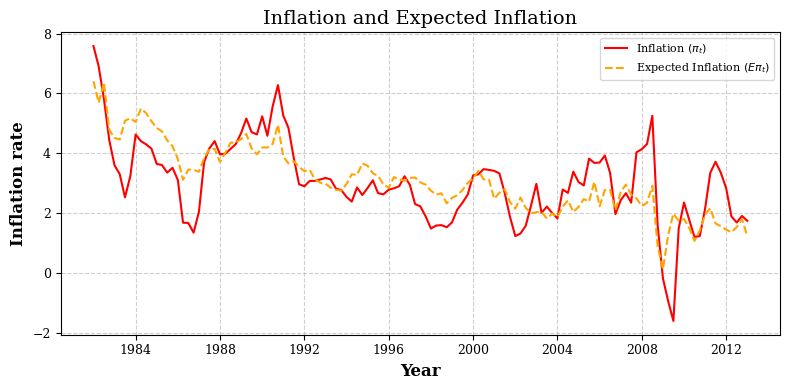

In [118]:
# --- 2×2 graph ---
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

# --- 1. Inflation and Expected Inflation ---
ax1 = axs
ax1.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', color='red')
ax1.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')
ax1.set_xlabel('Year', fontsize=12, weight='bold')
ax1.set_ylabel('Inflation rate', fontsize=12, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title('Inflation and Expected Inflation', fontsize=14)
ax1.legend(fontsize=8)

# --- Layout ---
plt.tight_layout()
plt.show()

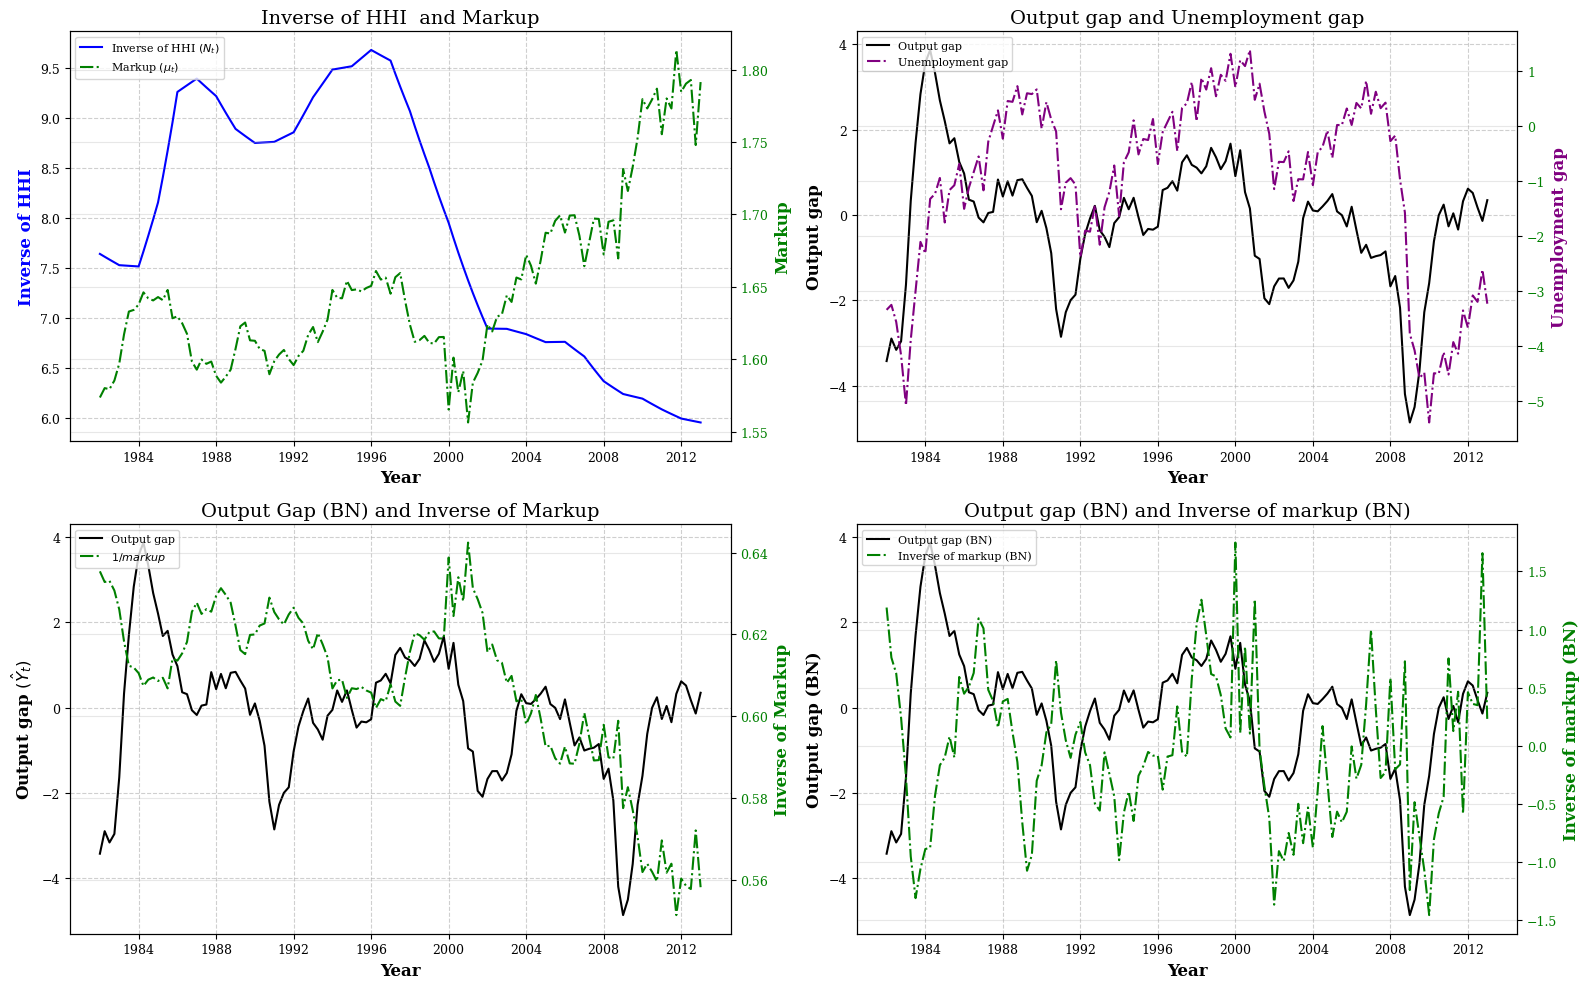

In [119]:
# --- 2×2 graph ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# --- 2. Number of Firms and Markup ---
ax1 = axs[0, 0]
ax1_left = ax1
ax1_right = ax1_left.twinx()
ax1_left.plot(data["DATE"], data["N"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax1_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax1_left.set_xlabel('Year', fontsize=12, weight='bold')
ax1_left.set_ylabel('Inverse of HHI', fontsize=12, weight='bold', color = 'blue')
ax1_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax1_right.tick_params(axis='y', labelcolor='green')
ax1_left.grid(True, linestyle='--', alpha=0.6)
ax1_left.set_title('Inverse of HHI  and Markup', fontsize=14)
lines = ax1_left.get_lines() + ax1_right.get_lines()
labels = [line.get_label() for line in lines]
ax1_left.legend(lines, labels, loc='upper left', fontsize=8)

ax2 = axs[0, 1]
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["output_gap_BN"], label='Output gap', color='black')
ax2_right.plot(data["DATE"], data["unemp_gap"], label='Unemployment gap', linestyle='-.', color='purple')
ax2_left.set_xlabel('Year', fontsize=12, weight='bold')
ax2_left.set_ylabel('Output gap', fontsize=12, weight='bold', color = 'black')
ax2_right.set_ylabel('Unemployment gap', fontsize=12, weight='bold', color='purple')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Output gap and Unemployment gap', fontsize=14)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)


# --- 3. Output Gap and Inverse Markup ---
ax3 = axs[1, 0]
ax3_left = ax3
ax3_right = ax3_left.twinx()
ax3_left.plot(data["DATE"], data["output_gap_BN"], label='Output gap', color='black')
ax3_right.plot(data["DATE"], 1/data["markup"], label=r'$1/markup$', linestyle='-.', color='green')
ax3_left.set_xlabel('Year', fontsize=12, weight='bold')
ax3_left.set_ylabel(r'Output gap $(\hat{Y}_t)$', fontsize=12, weight='bold')
ax3_right.set_ylabel('Inverse of Markup', fontsize=12, weight='bold', color='green')
ax3_right.tick_params(axis='y', labelcolor='green')
ax3_left.grid(True, linestyle='--', alpha=0.6)
ax3_left.set_title('Output Gap (BN) and Inverse of Markup', fontsize=14)
lines = ax3_left.get_lines() + ax3_right.get_lines()
labels = [line.get_label() for line in lines]
ax3_left.legend(lines, labels, loc='upper left', fontsize=8)

ax4 = axs[1, 1]
ax4_left = ax4
ax4_right = ax4_left.twinx()
ax4_left.plot(data["DATE"], data["output_gap_BN"], label=r'Output gap (BN)', color='black')
ax4_right.plot(data["DATE"], data["markup_BN_inv"], label=r'Inverse of markup (BN)', linestyle='-.', color='green')
ax4_left.set_xlabel('Year', fontsize=12, weight='bold')
ax4_left.set_ylabel('Output gap (BN)', fontsize=12, weight='bold', color='black')
ax4_right.set_ylabel('Inverse of markup (BN)', fontsize=12, weight='bold', color='green')
ax4_right.tick_params(axis='y', labelcolor='green')
ax4_left.grid(True, linestyle='--', alpha=0.6)
ax4_left.set_title('Output gap (BN) and Inverse of markup (BN)', fontsize=14)
lines = ax4_left.get_lines() + ax4_right.get_lines()
labels = [line.get_label() for line in lines]
ax4_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- Layout ---
plt.tight_layout()
plt.show()

In [120]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Beta(12, 12),
        "kappa"      : dist.Normal(0, 0.05),
        "theta"      : dist.Normal(0, 0.05), 
        "n"          : dist.Normal(0, 0.1), 
        # Sigma
        "sigma_u"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eps"  : dist.InverseGamma(0.001, 0.001),  
        "sigma_v"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_mu"   : dist.InverseGamma(0.001, 0.001),  
        "sigma_e"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eta"  : dist.InverseGamma(0.001, 0.001),  
    }
    return priors

In [121]:
# model
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)


# Estimation and Posterior Distributions

In [122]:
warmup= 1000
samples=9000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

In [123]:
# x_1 = x_markup_1
# x_2 = x_markup_2
# # NKPC under CES before financial crisis =================================================
# print("NKPC under CES/ markup")
# kernel = NUTS(model_0, target_accept_prob=0.995)
# mcmc_0_1_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
# mcmc_0_1_markup.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1)
# idata_0_1_markup = az.from_numpyro(mcmc_0_1_markup)
# posterior_samples = mcmc_0_1_markup.get_samples()
# diverging  = idata_0_1_markup.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
# print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# # NKPC under CES after financial crisis =================================================
# kernel = NUTS(model_0, target_accept_prob=0.995)    
# mcmc_0_2_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
# mcmc_0_2_markup.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2)
# idata_0_2_markup = az.from_numpyro(mcmc_0_2_markup)
# posterior_samples_2 = mcmc_0_2_markup.get_samples()
# diverging  = idata_0_2_markup.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
# print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

x_1 = x_output_gap_1
x_2 = x_output_gap_2
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/ output gap")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_1_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_1_output.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1)
idata_0_1_output = az.from_numpyro(mcmc_0_1_output)
posterior_samples = mcmc_0_1_output.get_samples()
diverging  = idata_0_1_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under CES after financial crisis =================================================
kernel = NUTS(model_0, target_accept_prob=0.995)    
mcmc_0_2_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_2_output.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2)
idata_0_2_output = az.from_numpyro(mcmc_0_2_output)
posterior_samples_2 = mcmc_0_2_output.get_samples()
diverging  = idata_0_2_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

# x_1 = x_markup_dt_1
# x_2 = x_markup_dt_2
# # NKPC under CES before financial crisis =================================================
# print("NKPC under CES/ markup (inverse)")
# kernel = NUTS(model_0, target_accept_prob=0.995)
# mcmc_0_1_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
# mcmc_0_1_markup_dt.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1)
# idata_0_1_markup_dt = az.from_numpyro(mcmc_0_1_markup_dt)
# posterior_samples_1_markup_dt = mcmc_0_1_markup_dt.get_samples()
# diverging  = idata_0_1_markup_dt.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
# print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# # NKPC under CES after financial crisis =================================================
# kernel = NUTS(model_0, target_accept_prob=0.995)    
# mcmc_0_2_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
# mcmc_0_2_markup_dt.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2)
# idata_0_2_markup_dt = az.from_numpyro(mcmc_0_2_markup_dt)
# posterior_samples_2_markup_dt = mcmc_0_2_markup_dt.get_samples()
# diverging  = idata_0_2_markup_dt.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
# print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

# x_1 = x_unempgap_1
# x_2 = x_unempgap_2
# # NKPC under CES before financial crisis =================================================
# print("NKPC under CES/unemployment gap")
# kernel = NUTS(model_0, target_accept_prob=0.995)
# mcmc_0_1_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
# mcmc_0_1_unempgap.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1)
# idata_0_1_unempgap = az.from_numpyro(mcmc_0_1_unempgap)
# posterior_samples_1_unempgap = mcmc_0_1_unempgap.get_samples()
# diverging  = idata_0_1_unempgap.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
# print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# # NKPC under CES after financial crisis =================================================
# kernel = NUTS(model_0, target_accept_prob=0.995)    
# mcmc_0_2_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
# mcmc_0_2_unempgap.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2)
# idata_0_2_unempgap = az.from_numpyro(mcmc_0_2_unempgap)
# posterior_samples_2_unempgap = mcmc_0_2_unempgap.get_samples()
# diverging  = idata_0_2_unempgap.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
# print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param


NKPC under CES/ output gap


sample: 100%|██████████| 10000/10000 [00:03<00:00, 2559.37it/s, 15 steps of size 2.01e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%


sample: 100%|██████████| 10000/10000 [00:02<00:00, 4094.43it/s, 15 steps of size 2.16e-01. acc. prob=0.99]

model 0: divergence ratio = 0.0000%


In [124]:
import os
import numpy as np
import pandas as pd
from scipy.stats import norm, gaussian_kde

# ---- SDDR(BF_01) for kappa with Normal(0,0.01) prior ----
def sddr(idata, mu=0.0, sigma=0.1):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["kappa"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety
    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])
    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=mu, scale=sigma)
    return post_at0 / max(prior_at0, 1e-300)

# ---- Collect models ----
models = [
    ("CES: Markup - pre",        idata_0_1_markup),
    ("CES: Markup - post",        idata_0_2_markup),
    # ("CES: Output gap - pre",    idata_0_1_output),
    # ("CES: Output gap - post",    idata_0_2_output),
    # ("CES: Markup (BN) - pre",   idata_0_1_markup_dt),
    # ("CES: Markup (BN) - post",   idata_0_2_markup_dt),
    # ("CES: Unemp. gap - pre",    idata_0_1_unempgap),
    # ("CES: Unemp. gap - post",    idata_0_2_unempgap),
]

rows = []
for name, idata in models:
    bf01 = sddr(idata, mu=0.0, sigma=0.1)
    rows.append({"Model": name, "SDDR_BF01_kappa": bf01})

df_sddr = pd.DataFrame(rows)

# ---- Save to Markdown (no extra deps) ----
def df_to_markdown(df: pd.DataFrame) -> str:
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join([":---" for _ in df.columns]) + " |"
    lines = ["| " + " | ".join(f"{v:.5f}" if isinstance(v,(int,float,np.floating)) and np.isfinite(v) else str(v) for v in row) + " |"
             for row in df.itertuples(index=False, name=None)]
    return "\n".join([header, separator] + lines)

outdir = "../estimated_coef"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "ces_sddr_hmc_fc.md")

with open(outfile, "w", encoding="utf-8") as f:
    f.write(df_to_markdown(df_sddr))

print("Saved:", outfile)
display(df_sddr)

Saved: ../estimated_coef/ces_sddr_hmc_fc.md


,Model,SDDR_BF01_kappa
0,CES: Markup - pre,1.764496
1,CES: Markup - post,1.987715


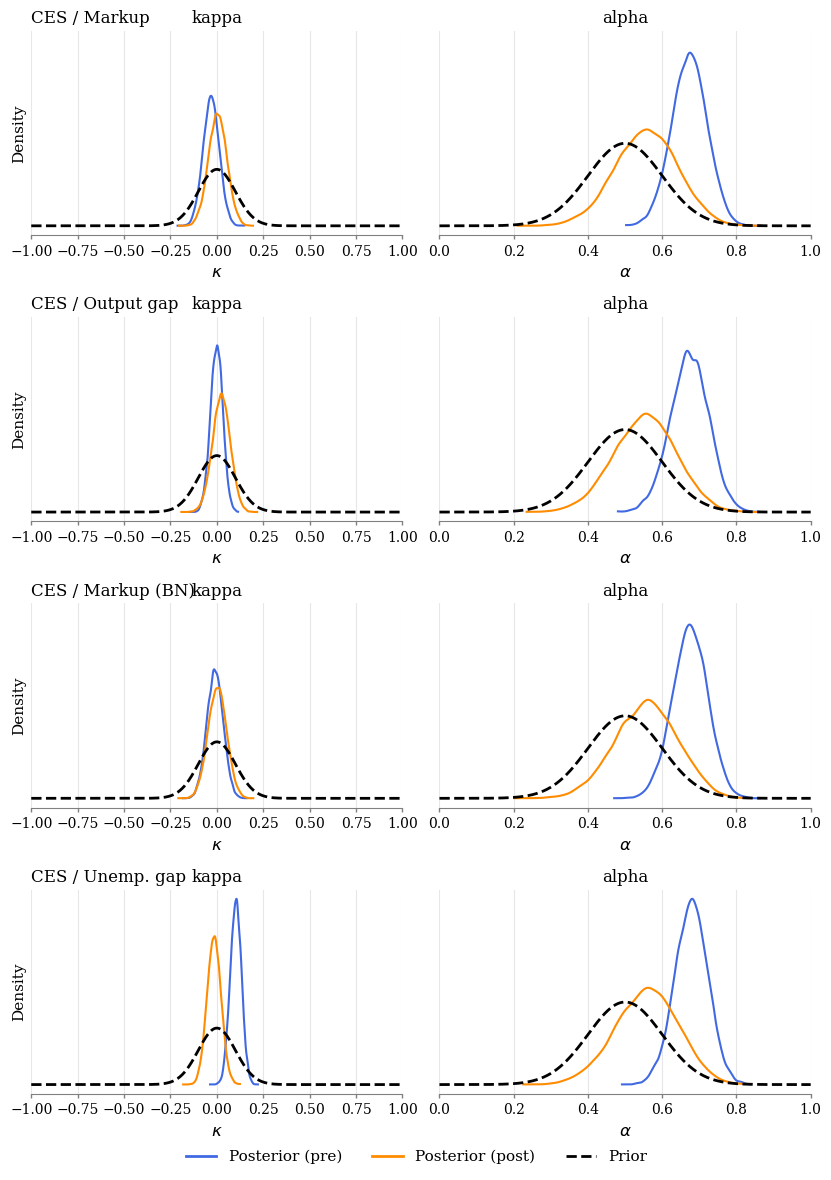

In [125]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm

def plot_prior_posterior_prepost_grid(idata_pairs, labels,
                                      params=("kappa","alpha"),
                                      figsize_per=(4.0, 2.8),
                                      savepath=None,
                                      xlims=None,
                                      prior_spec=None):
    """
    idata_pairs : list of dicts like [{"pre": idata_pre, "post": idata_post}, ...]
                  length = number of rows
    labels      : list of row labels (same length as idata_pairs)
    params      : tuple of variable names to plot as columns
    figsize_per : (width,height) per subplot; total = (w*#cols, h*#rows)
    xlims       : optional dict, e.g., {"kappa": (-0.05,0.05), "alpha": (0,1)}
    prior_spec  : optional dict for priors
                  default: {"alpha":{"mu":0.5,"sigma":0.1}, "kappa":{"mu":0.0,"sigma":0.01}}
    """

    assert len(idata_pairs) == len(labels), "len(idata_pairs) must equal len(labels)"
    n_rows = len(idata_pairs)
    n_cols = len(params)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize_per[0]*n_cols, figsize_per[1]*n_rows),
                             squeeze=False, sharey='col')

    # default priors
    if prior_spec is None:
        prior_spec = {
            "alpha": {"mu": 0.5, "sigma": 0.1},
            "kappa": {"mu": 0.0, "sigma": 0.1},
        }

    # plotting options
    color_pre  = "royalblue"
    color_post = "darkorange"

    for i, (pair, label_row) in enumerate(zip(idata_pairs, labels)):
        for j, param in enumerate(params):
            ax = axes[i, j]

            # --- POSTERIOR (pre) ---
            if "pre" in pair and pair["pre"] is not None:
                az.plot_posterior(
                    pair["pre"],
                    var_names=[param],
                    point_estimate=None,
                    hdi_prob="hide",
                    kind="kde",
                    color=color_pre,
                    ax=ax,
                )

            # --- POSTERIOR (post) ---
            if "post" in pair and pair["post"] is not None:
                az.plot_posterior(
                    pair["post"],
                    var_names=[param],
                    point_estimate=None,
                    hdi_prob="hide",
                    kind="kde",
                    color=color_post,
                    ax=ax,
                )

            # --- PRIOR ---
            if param in prior_spec:
                mu  = prior_spec[param]["mu"]
                sig = prior_spec[param]["sigma"]
                if xlims and param in xlims:
                    xmin, xmax = xlims[param]
                else:
                    xmin, xmax = mu - 5*sig, mu + 5*sig
                x = np.linspace(xmin, xmax, 1000)
                y = norm.pdf(x, mu, sig)
                ax.plot(x, y, "k--", lw=2, label="Prior")  # dashed black

            # labels & xlim
            if j == 0:
                ax.set_ylabel("Density", fontsize=11)
                ax.set_title(label_row, fontsize=12, loc="left")
            else:
                ax.set_ylabel("")
            ax.set_xlabel({"kappa": r"$\kappa$", "alpha": r"$\alpha$"}.get(param, param),
                          fontsize=12)
            ax.tick_params(labelsize=10)
            if xlims and param in xlims:
                ax.set_xlim(xlims[param])

    # unified legend
    handles = [
        Line2D([0],[0], color=color_pre,  lw=2, label="Posterior (pre)"),
        Line2D([0],[0], color=color_post, lw=2, label="Posterior (post)"),
        Line2D([0],[0], color="k",       lw=2, ls="--", label="Prior"),
    ]
    fig.legend(handles=handles, fontsize=11, loc="lower center",
               ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, bbox_inches="tight", dpi=300)

    return fig


idata_pairs = [
    {"pre": idata_0_1_markup,     "post": idata_0_2_markup},      # CES / Markup
    {"pre": idata_0_1_output,     "post": idata_0_2_output},      # CES / Output gap
    {"pre": idata_0_1_markup_dt,  "post": idata_0_2_markup_dt},   # CES / Markup (BN / inverse)
    {"pre": idata_0_1_unempgap,   "post": idata_0_2_unempgap},    # CES / Unemp gap
]

labels = [
    "CES / Markup",
    "CES / Output gap",
    "CES / Markup (BN)",
    "CES / Unemp. gap",
]

fig = plot_prior_posterior_prepost_grid(
    idata_pairs=idata_pairs,
    labels=labels,
    params=("kappa", "alpha"),
    figsize_per=(4.2, 2.9),  
    savepath="../figure/ces_results_hmc_fc.png",
    xlims={"kappa": (-1, 1), "alpha": (0, 1)},
    prior_spec={"alpha":{"mu":0.5,"sigma":0.1},
                "kappa":{"mu":0.0,"sigma":0.1}}
)
plt.show()

In [126]:
x_1 = x_output_gap_1
x_2 = x_output_gap_2
# NKPC under HSA : no shift in slope / before financial crisis ==============================
print("NKPC under HSA : no shift in slope, before financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_1_output_gap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_1_output_gap.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
idata_1_1_output_gap = az.from_numpyro(mcmc_1_1_output_gap)
posterior_samples_1_1_output_gap = mcmc_1_1_output_gap.get_samples()
N_bar_samples_1_1_output_gap = posterior_samples_1_1_output_gap["Nbar"]
N_bar_mean_1_1_output_gap = np.mean(N_bar_samples_1_1_output_gap, axis=0) 
N_bar_std_1_1_output_gap = np.std(N_bar_samples_1_1_output_gap, axis=0)  
N_bar_lower_1_1_output_gap = N_bar_mean_1_1_output_gap - 1.97 * N_bar_std_1_1_output_gap
N_bar_upper_1_1_output_gap = N_bar_mean_1_1_output_gap + 1.97 * N_bar_std_1_1_output_gap
N_hat_samples_1_1_output_gap = posterior_samples_1_1_output_gap["Nhat"]
N_hat_mean_1_1_output_gap = np.mean(N_hat_samples_1_1_output_gap, axis=0) 
N_hat_std_1_1_output_gap = np.std(N_hat_samples_1_1_output_gap, axis=0)  
N_hat_lower_1_1_output_gap = N_hat_mean_1_1_output_gap - 1.97 * N_hat_std_1_1_output_gap
N_hat_upper_1_1_output_gap = N_hat_mean_1_1_output_gap + 1.97 * N_hat_std_1_1_output_gap
diverging  = idata_1_1_output_gap.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# NKPC under HSA : no shift in slope / after financial crisis ==============================
print("NKPC under HSA : no shift in slope, after financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_2_output_gap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_2_output_gap.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
idata_1_2_output_gap = az.from_numpyro(mcmc_1_2_output_gap)
posterior_samples_1_2_output_gap = mcmc_1_2_output_gap.get_samples()
N_bar_samples_1_2_output_gap = posterior_samples_1_2_output_gap["Nbar"]
N_bar_mean_1_2_output_gap = np.mean(N_bar_samples_1_2_output_gap, axis=0) 
N_bar_std_1_2_output_gap = np.std(N_bar_samples_1_2_output_gap, axis=0)  
N_bar_lower_1_2_output_gap = N_bar_mean_1_2_output_gap - 1.97 * N_bar_std_1_2_output_gap
N_bar_upper_1_2_output_gap = N_bar_mean_1_2_output_gap + 1.97 * N_bar_std_1_2_output_gap
N_hat_samples_1_2_output_gap = posterior_samples_1_2_output_gap["Nhat"]
N_hat_mean_1_2_output_gap = np.mean(N_hat_samples_1_2_output_gap, axis=0) 
N_hat_std_1_2_output_gap = np.std(N_hat_samples_1_2_output_gap, axis=0)  
N_hat_lower_1_2_output_gap = N_hat_mean_1_2_output_gap - 1.97 * N_hat_std_1_2_output_gap
N_hat_upper_1_2_output_gap = N_hat_mean_1_2_output_gap + 1.97 * N_hat_std_1_2_output_gap
diverging  = idata_1_2_output_gap.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# x_1 = x_markup_1
# x_2 = x_markup_2
# # NKPC under HSA : no shift in slope / before financial crisis ==============================
# print("NKPC under HSA : no shift in slope, before financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_1_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_1_markup.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
# idata_1_1_markup = az.from_numpyro(mcmc_1_1_markup)
# posterior_samples_1_1_markup = mcmc_1_1_markup.get_samples()
# N_bar_samples_1_1_markup = posterior_samples_1_1_markup["Nbar"]
# N_bar_mean_1_1_markup = np.mean(N_bar_samples_1_1_markup, axis=0) 
# N_bar_std_1_1_markup = np.std(N_bar_samples_1_1_markup, axis=0)  
# N_bar_lower_1_1_markup = N_bar_mean_1_1_markup - 1.97 * N_bar_std_1_1_markup
# N_bar_upper_1_1_markup = N_bar_mean_1_1_markup + 1.97 * N_bar_std_1_1_markup
# N_hat_samples_1_1_markup = posterior_samples_1_1_markup["Nhat"]
# N_hat_mean_1_1_markup = np.mean(N_hat_samples_1_1_markup, axis=0) 
# N_hat_std_1_1_markup = np.std(N_hat_samples_1_1_markup, axis=0)  
# N_hat_lower_1_1_markup = N_hat_mean_1_1_markup - 1.97 * N_hat_std_1_1_markup
# N_hat_upper_1_1_markup = N_hat_mean_1_1_markup + 1.97 * N_hat_std_1_1_markup
# diverging  = idata_1_1_markup.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# # NKPC under HSA : no shift in slope / after financial crisis ==============================
# print("NKPC under HSA : no shift in slope, after financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_2_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_2_markup.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
# idata_1_2_markup = az.from_numpyro(mcmc_1_2_markup)
# posterior_samples_1_2_markup = mcmc_1_2_markup.get_samples()
# N_bar_samples_1_2_markup = posterior_samples_1_2_markup["Nbar"]
# N_bar_mean_1_2_markup = np.mean(N_bar_samples_1_2_markup, axis=0) 
# N_bar_std_1_2_markup = np.std(N_bar_samples_1_2_markup, axis=0)  
# N_bar_lower_1_2_markup = N_bar_mean_1_2_markup - 1.97 * N_bar_std_1_2_markup
# N_bar_upper_1_2_markup = N_bar_mean_1_2_markup + 1.97 * N_bar_std_1_2_markup
# N_hat_samples_1_2_markup = posterior_samples_1_2_markup["Nhat"]
# N_hat_mean_1_2_markup = np.mean(N_hat_samples_1_2_markup, axis=0) 
# N_hat_std_1_2_markup = np.std(N_hat_samples_1_2_markup, axis=0)  
# N_hat_lower_1_2_markup = N_hat_mean_1_2_markup - 1.97 * N_hat_std_1_2_markup
# N_hat_upper_1_2_markup = N_hat_mean_1_2_markup + 1.97 * N_hat_std_1_2_markup
# diverging  = idata_1_2_markup.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

# x_1 = x_markup_dt_1
# x_2 = x_markup_dt_2
# # NKPC under HSA : no shift in slope / before financial crisis ==============================
# print("NKPC under HSA : no shift in slope, before financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_1_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_1_markup_dt.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
# idata_1_1_markup_dt = az.from_numpyro(mcmc_1_1_markup_dt)
# posterior_samples_1_1_markup_dt = mcmc_1_1_markup_dt.get_samples()
# N_bar_samples_1_1_markup_dt = posterior_samples_1_1_markup_dt["Nbar"]
# N_bar_mean_1_1_markup_dt = np.mean(N_bar_samples_1_1_markup_dt, axis=0) 
# N_bar_std_1_1_markup_dt = np.std(N_bar_samples_1_1_markup_dt, axis=0)  
# N_bar_lower_1_1_markup_dt = N_bar_mean_1_1_markup_dt - 1.97 * N_bar_std_1_1_markup_dt
# N_bar_upper_1_1_markup_dt = N_bar_mean_1_1_markup_dt + 1.97 * N_bar_std_1_1_markup_dt
# N_hat_samples_1_1_markup_dt = posterior_samples_1_1_markup_dt["Nhat"]
# N_hat_mean_1_1_markup_dt = np.mean(N_hat_samples_1_1_markup_dt, axis=0) 
# N_hat_std_1_1_markup_dt = np.std(N_hat_samples_1_1_markup_dt, axis=0)  
# N_hat_lower_1_1_markup_dt = N_hat_mean_1_1_markup_dt - 1.97 * N_hat_std_1_1_markup_dt
# N_hat_upper_1_1_markup_dt = N_hat_mean_1_1_markup_dt + 1.97 * N_hat_std_1_1_markup_dt
# diverging  = idata_1_1_markup_dt.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# # NKPC under HSA : no shift in slope / after financial crisis ==============================
# print("NKPC under HSA : no shift in slope, after financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_2_markup_dt = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_2_markup_dt.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
# idata_1_2_markup_dt = az.from_numpyro(mcmc_1_2_markup_dt)
# posterior_samples_1_2_markup_dt = mcmc_1_2_markup_dt.get_samples()
# N_bar_samples_1_2_markup_dt = posterior_samples_1_2_markup_dt["Nbar"]
# N_bar_mean_1_2_markup_dt = np.mean(N_bar_samples_1_2_markup_dt, axis=0) 
# N_bar_std_1_2_markup_dt = np.std(N_bar_samples_1_2_markup_dt, axis=0)  
# N_bar_lower_1_2_markup_dt = N_bar_mean_1_2_markup_dt - 1.97 * N_bar_std_1_2_markup_dt
# N_bar_upper_1_2_markup_dt = N_bar_mean_1_2_markup_dt + 1.97 * N_bar_std_1_2_markup_dt
# N_hat_samples_1_2_markup_dt = posterior_samples_1_2_markup_dt["Nhat"]
# N_hat_mean_1_2_markup_dt = np.mean(N_hat_samples_1_2_markup_dt, axis=0) 
# N_hat_std_1_2_markup_dt = np.std(N_hat_samples_1_2_markup_dt, axis=0)  
# N_hat_lower_1_2_markup_dt = N_hat_mean_1_2_markup_dt - 1.97 * N_hat_std_1_2_markup_dt
# N_hat_upper_1_2_markup_dt = N_hat_mean_1_2_markup_dt + 1.97 * N_hat_std_1_2_markup_dt
# diverging  = idata_1_2_markup_dt.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# x_1 = x_unempgap_1
# x_2 = x_unempgap_2
# # NKPC under HSA : no shift in slope / before financial crisis ==============================
# print("NKPC under HSA : no shift in slope, before financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_1_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_1_unempgap.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_1, N = N_1, l=len(pi_1))
# idata_1_1_unempgap = az.from_numpyro(mcmc_1_1_unempgap)
# posterior_samples_1_1_unempgap = mcmc_1_1_unempgap.get_samples()
# N_bar_samples_1_1_unempgap = posterior_samples_1_1_unempgap["Nbar"]
# N_bar_mean_1_1_unempgap = np.mean(N_bar_samples_1_1_unempgap, axis=0) 
# N_bar_std_1_1_unempgap = np.std(N_bar_samples_1_1_unempgap, axis=0)  
# N_bar_lower_1_1_unempgap = N_bar_mean_1_1_unempgap - 1.97 * N_bar_std_1_1_unempgap
# N_bar_upper_1_1_unempgap = N_bar_mean_1_1_unempgap + 1.97 * N_bar_std_1_1_unempgap
# N_hat_samples_1_1_unempgap = posterior_samples_1_1_unempgap["Nhat"]
# N_hat_mean_1_1_unempgap = np.mean(N_hat_samples_1_1_unempgap, axis=0) 
# N_hat_std_1_1_unempgap = np.std(N_hat_samples_1_1_unempgap, axis=0)  
# N_hat_lower_1_1_unempgap = N_hat_mean_1_1_unempgap - 1.97 * N_hat_std_1_1_unempgap
# N_hat_upper_1_1_unempgap = N_hat_mean_1_1_unempgap + 1.97 * N_hat_std_1_1_unempgap
# diverging  = idata_1_1_unempgap.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# # NKPC under HSA : no shift in slope / after financial crisis ==============================
# print("NKPC under HSA : no shift in slope, after financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_2_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_2_unempgap.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_2, N = N_2, l=len(pi_2))
# idata_1_2_unempgap = az.from_numpyro(mcmc_1_2_unempgap)
# posterior_samples_1_2_unempgap = mcmc_1_2_unempgap.get_samples()
# N_bar_samples_1_2_unempgap = posterior_samples_1_2_unempgap["Nbar"]
# N_bar_mean_1_2_unempgap = np.mean(N_bar_samples_1_2_unempgap, axis=0) 
# N_bar_std_1_2_unempgap = np.std(N_bar_samples_1_2_unempgap, axis=0)  
# N_bar_lower_1_2_unempgap = N_bar_mean_1_2_unempgap - 1.97 * N_bar_std_1_2_unempgap
# N_bar_upper_1_2_unempgap = N_bar_mean_1_2_unempgap + 1.97 * N_bar_std_1_2_unempgap
# N_hat_samples_1_2_unempgap = posterior_samples_1_2_unempgap["Nhat"]
# N_hat_mean_1_2_unempgap = np.mean(N_hat_samples_1_2_unempgap, axis=0) 
# N_hat_std_1_2_unempgap = np.std(N_hat_samples_1_2_unempgap, axis=0)  
# N_hat_lower_1_2_unempgap = N_hat_mean_1_2_unempgap - 1.97 * N_hat_std_1_2_unempgap
# N_hat_upper_1_2_unempgap = N_hat_mean_1_2_unempgap + 1.97 * N_hat_std_1_2_unempgap
# diverging  = idata_1_2_unempgap.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

NKPC under HSA : no shift in slope, before financial crisis


sample: 100%|██████████| 10000/10000 [05:44<00:00, 29.04it/s, 255 steps of size 2.77e-02. acc. prob=0.94]


Model 1 : divergence ratio = 0.0000%
NKPC under HSA : no shift in slope, after financial crisis


sample: 100%|██████████| 10000/10000 [00:46<00:00, 214.13it/s, 127 steps of size 1.76e-02. acc. prob=0.92]


Model 1 : divergence ratio = 14.9111%


In [127]:
# ---- Collect models ----
models = [
    # ("HSA: Markup - pre",        idata_1_1_markup),
    # ("HSA: Markup - post",        idata_1_2_markup),
    ("HSA: Output gap - pre",    idata_1_1_output_gap),
    ("HSA: Output gap - post",    idata_1_2_output_gap),
    # ("HSA: Markup (BN) - pre",   idata_1_1_markup_dt),
    # ("HSA: Markup (BN) - post",   idata_1_2_markup_dt),
    # ("HSA: Unemp. gap - pre",    idata_1_1_unempgap),
    # ("HSA: Unemp. gap - post",    idata_1_2_unempgap),
]

rows = []
for name, idata in models:
    bf01 = sddr(idata, mu=0, sigma=0.1)
    rows.append({"Model": name, "SDDR_BF01_kappa": bf01})

df_sddr = pd.DataFrame(rows)

# ---- Save to Markdown (no extra deps) ----
def df_to_markdown(df: pd.DataFrame) -> str:
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join([":---" for _ in df.columns]) + " |"
    lines = ["| " + " | ".join(f"{v:.5f}" if isinstance(v,(int,float,np.floating)) and np.isfinite(v) else str(v) for v in row) + " |"
             for row in df.itertuples(index=False, name=None)]
    return "\n".join([header, separator] + lines)

outdir = "../estimated_coef"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "hsa_sddr_hmc_fc.md")

with open(outfile, "w", encoding="utf-8") as f:
    f.write(df_to_markdown(df_sddr))

print("Saved:", outfile)
display(df_sddr)

Saved: ../estimated_coef/hsa_sddr_hmc_fc.md


,Model,SDDR_BF01_kappa
0,HSA: Output gap - pre,2.993972
1,HSA: Output gap - post,1.463888


In [128]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm

def plot_prior_posterior_prepost_grid(idata_pairs, labels,
                                      params=("kappa","alpha"),
                                      figsize_per=(4.0, 2.8),
                                      savepath=None,
                                      xlims=None,
                                      prior_spec=None):
    """
    idata_pairs : list of dicts like [{"pre": idata_pre, "post": idata_post}, ...]
                  length = number of rows
    labels      : list of row labels (same length as idata_pairs)
    params      : tuple of variable names to plot as columns
    figsize_per : (width,height) per subplot; total = (w*#cols, h*#rows)
    xlims       : optional dict, e.g., {"kappa": (-0.05,0.05), "alpha": (0,1)}
    prior_spec  : optional dict for priors
                  default: {"alpha":{"mu":0.5,"sigma":0.1}, "kappa":{"mu":0.0,"sigma":0.01}}
    """

    assert len(idata_pairs) == len(labels), "len(idata_pairs) must equal len(labels)"
    n_rows = len(idata_pairs)
    n_cols = len(params)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize_per[0]*n_cols, figsize_per[1]*n_rows),
                             squeeze=False, sharey='col')

    # default priors
    if prior_spec is None:
        prior_spec = {
            "alpha": {"mu": 0.5, "sigma": 0.1},
            "kappa": {"mu": 0.0, "sigma": 0.1},
            "theta": {"mu": 0.0, "sigma": 0.1},
        }

    # plotting options
    color_pre  = "royalblue"
    color_post = "darkorange"

    for i, (pair, label_row) in enumerate(zip(idata_pairs, labels)):
        for j, param in enumerate(params):
            ax = axes[i, j]

            # --- POSTERIOR (pre) ---
            if "pre" in pair and pair["pre"] is not None:
                az.plot_posterior(
                    pair["pre"],
                    var_names=[param],
                    point_estimate=None,
                    hdi_prob="hide",
                    kind="kde",
                    color=color_pre,
                    ax=ax,
                )

            # --- POSTERIOR (post) ---
            if "post" in pair and pair["post"] is not None:
                az.plot_posterior(
                    pair["post"],
                    var_names=[param],
                    point_estimate=None,
                    hdi_prob="hide",
                    kind="kde",
                    color=color_post,
                    ax=ax,
                )

            # --- PRIOR ---
            if param in prior_spec:
                mu  = prior_spec[param]["mu"]
                sig = prior_spec[param]["sigma"]
                if xlims and param in xlims:
                    xmin, xmax = xlims[param]
                else:
                    xmin, xmax = mu - 5*sig, mu + 5*sig
                x = np.linspace(xmin, xmax, 1000)
                y = norm.pdf(x, mu, sig)
                ax.plot(x, y, "k--", lw=2, label="Prior")  # dashed black

            # labels & xlim
            if j == 0:
                ax.set_ylabel("Density", fontsize=11)
                ax.set_title(label_row, fontsize=12, loc="left")
            else:
                ax.set_ylabel("")
            ax.set_xlabel({"kappa": r"$\kappa$", "alpha": r"$\alpha$"}.get(param, param),
                          fontsize=12)
            ax.tick_params(labelsize=10)
            if xlims and param in xlims:
                ax.set_xlim(xlims[param])

    # unified legend
    handles = [
        Line2D([0],[0], color=color_pre,  lw=2, label="Posterior (pre)"),
        Line2D([0],[0], color=color_post, lw=2, label="Posterior (post)"),
        Line2D([0],[0], color="k",       lw=2, ls="--", label="Prior"),
    ]
    fig.legend(handles=handles, fontsize=11, loc="lower center",
               ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, bbox_inches="tight", dpi=300)

    return fig


idata_pairs = [
    # {"pre": idata_1_1_markup,     "post": idata_1_2_markup},      # CES / Markup
    {"pre": idata_1_1_output_gap,  "post": idata_1_2_output_gap},      # CES / Output gap
    # {"pre": idata_1_1_markup_dt,  "post": idata_1_2_markup_dt},   # CES / Markup (BN / inverse)
    # {"pre": idata_1_1_unempgap,   "post": idata_1_2_unempgap},    # CES / Unemp gap
]

labels = [
    "CES / Markup",
    "CES / Output gap",
    "CES / Markup (BN)",
    "CES / Unemp. gap",
]

fig = plot_prior_posterior_prepost_grid(
    idata_pairs=idata_pairs,
    labels=labels,
    params=("kappa", "alpha", "theta"),
    figsize_per=(4.2, 2.9),  
    savepath="../figure/hsa_results_hmc_fc.png",
    xlims={"kappa": (-0.05, 0.05), "alpha": (0, 1), "theta": (-0.02, 0.05)},
    prior_spec={"alpha":{"mu":0.5,"sigma":0.1},
                "kappa":{"mu":0,"sigma":0.1},
                "theta":{"mu":0,"sigma":0.1},
                }
)
plt.show()

AssertionError: len(idata_pairs) must equal len(labels)

In [ ]:
dict_idata = {
    # 'CES before FC: markup':idata_0_1_markup,
    # 'CES after FC: markup': idata_0_2_markup,
    # 'HSA before FC: markup': idata_1_1_markup,
    # 'HSA after FC: markup': idata_1_2_markup,
    # 'CES before FC: unemployment gap': idata_0_1_unempgap,
    # 'CES after FC: unemployment gap': idata_0_2_unempgap,
    # # 'HSA before FC: unemployment gap': idata_1_1_unempgap,
    # 'HSA after FC: unemployment gap': idata_1_2_unempgap,
    'CES before FC: output gap': idata_0_1_output,
    'CES after FC: output gap': idata_0_2_output,
    'HSA before FC: output gap': idata_1_1_output_gap,
    'HSA after FC: output gap': idata_1_2_output_gap,
    # 'CES before FC: unemp gap': idata_0_1_unempgap,
    # 'CES after FC: unemp gap': idata_0_2_unempgap,
    # 'HSA before FC: unemp gap': idata_1_1_unempgap,
    # 'HSA after FC: unemp gap': idata_1_2_unempgap,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)
outdir = "../estimated_coef"
fname = f"{outdir}/results_table_hmc_fc.md"
# Markdown 
def df_to_markdown(df):
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join([":---" for _ in df.columns]) + " |"
    rows = ["| " + " | ".join(map(str, row)) + " |" for row in df.values]
    return "\n".join([header, separator] + rows)

with open(fname, "w") as f:
    f.write(df_to_markdown(summary_df))

,model,alpha,kappa,theta,rho_1,rho_2,n
0,CES before FC: markup,0.6750000,0.0080000,-,-,-,-
1,CES after FC: markup,0.5570000,0.0100000,-,-,-,-
2,HSA before FC: markup,0.6740000,0.0080000,0.0100000,1.7760000,-0.8760000,-0.0120000
3,HSA after FC: markup,0.5570000,0.0100000,0.0100000,1.5490000,-0.7530000,-0.0180000
4,CES before FC: unemployment gap,0.6760000,0.0190000,-,-,-,-
5,CES after FC: unemployment gap,0.5570000,0.0090000,-,-,-,-
6,HSA before FC: unemployment gap,0.6740000,0.0190000,0.0100000,1.6470000,-0.8160000,-0.0120000
7,HSA after FC: unemployment gap,0.5560000,0.0090000,0.0100000,1.5290000,-0.7420000,-0.0180000
8,CES before FC: output gap,0.6800000,0.0090000,-,-,-,-
9,CES after FC: output gap,0.5550000,0.0110000,-,-,-,-


## Decomposition Check

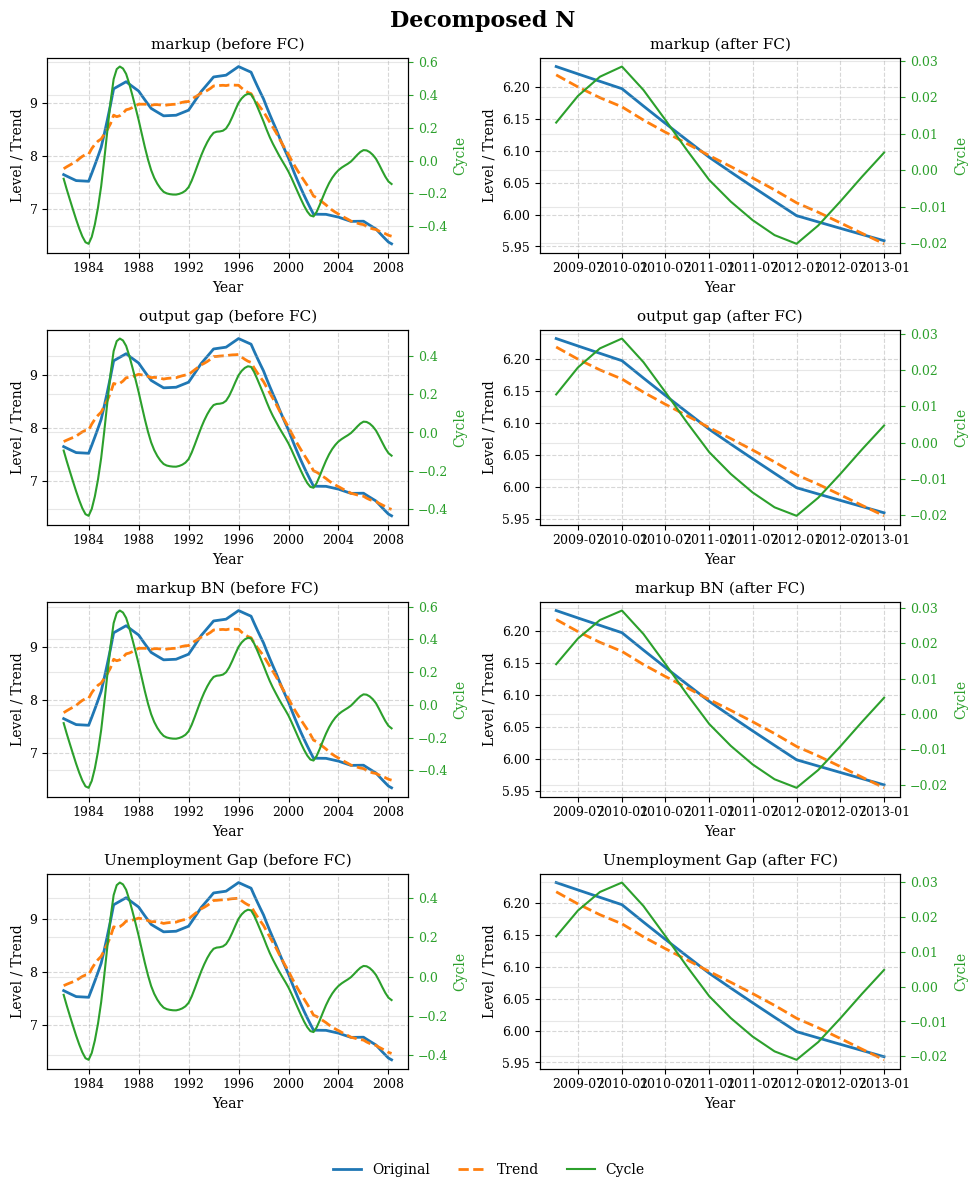

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12), sharex=False)
fig.suptitle("Decomposed N", fontsize=16, fontweight="bold")
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend
    ax.plot(date, original, label="Original", color=colors[0], linewidth=2)
    ax.plot(date, trend,    label="Trend",    color=colors[1], linestyle="--", linewidth=2)
    ax.set_xlabel("Year")
    ax.set_ylabel("Level / Trend")
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.5)
    # cycle (twin axis)
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2], linewidth=1.5)
    ax2.set_ylabel("Cycle", color=colors[2])
    ax2.tick_params(axis="y", colors=colors[2])
    # return handles for legend
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    return lines, labels

# handles, labels = plot_decomposition_ax(
#     axes[0,0], data_1["DATE"], data_1["N"], 
#     N_bar_mean_1_1_markup, N_hat_mean_1_1_markup,
#     "markup (before FC)", loc="lower right"
# )
# plot_decomposition_ax(
#     axes[0,1], data_2["DATE"], data_2["N"], 
#     N_bar_mean_1_2_markup, N_hat_mean_1_2_markup,
#     "markup (after FC)", loc="lower right"
# )
# plot_decomposition_ax(
#     axes[1,0], data_1["DATE"], data_1["N"], 
#     N_bar_mean_1_1_output_gap, N_hat_mean_1_1_output_gap,
#     "output gap (before FC)", loc="lower right"
# )
plot_decomposition_ax(
    axes[1,1], data_2["DATE"], data_2["N"], 
    N_bar_mean_1_2_output_gap, N_hat_mean_1_2_output_gap,
    "output gap (after FC)", loc="lower right"
)
# plot_decomposition_ax(
#     axes[2,0], data_1["DATE"], data_1["N"], 
#     N_bar_mean_1_1_markup_dt, N_hat_mean_1_1_markup_dt,
#     "markup BN (before FC)", loc="lower right"
# )
# plot_decomposition_ax(
#     axes[2,1], data_2["DATE"], data_2["N"], 
#     N_bar_mean_1_2_markup_dt, N_hat_mean_1_2_markup_dt,
#     "markup BN (after FC)", loc="lower right"
# )
# plot_decomposition_ax(
#     axes[3,0], data_1["DATE"], data_1["N"], 
#     N_bar_mean_1_1_unempgap, N_hat_mean_1_1_unempgap,
#     "Unemployment Gap (before FC)", loc="lower right"
# )
# plot_decomposition_ax(
#     axes[3,1], data_2["DATE"], data_2["N"], 
#     N_bar_mean_1_2_unempgap, N_hat_mean_1_2_unempgap,
#     "Unemployment Gap (after FC)", loc="lower right"
# )
# fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10)
plt.tight_layout(rect=[0,0.05,1,1])
plt.show()
outdir = "../figure"
fname = f"{outdir}/decomposition_hmc_fc.png"
plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

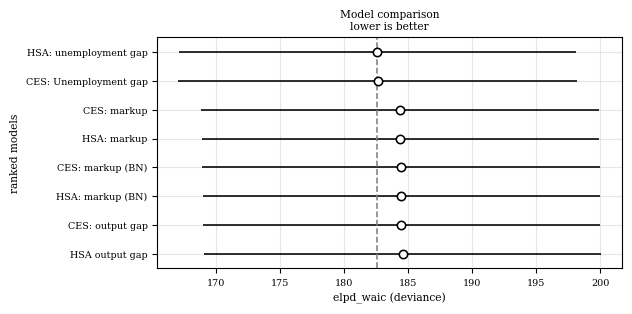

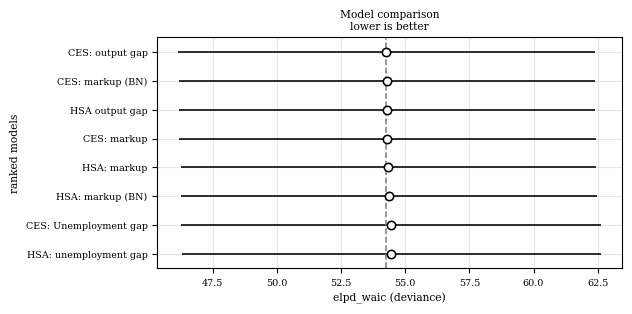

In [ ]:
dict_idata = {
    'CES: markup': idata_0_1_markup, 'HSA: markup': idata_1_1_markup, 
    'CES: markup (BN)': idata_0_1_markup_dt, 'HSA: markup (BN)': idata_1_1_markup_dt,
    'CES: output gap': idata_0_1_output, 'HSA output gap': idata_1_1_output_gap,
    'CES: Unemployment gap': idata_0_1_unempgap, 'HSA: unemployment gap': idata_1_1_unempgap
    }
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))
outdir = "../figure"
fname = f"{outdir}/waic_hmc_pre.png"
plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()
dict_idata = {
    'CES: markup': idata_0_2_markup, 'HSA: markup': idata_1_2_markup, 
    'CES: markup (BN)': idata_0_2_markup_dt, 'HSA: markup (BN)': idata_1_2_markup_dt,
    'CES: output gap': idata_0_2_output, 'HSA output gap': idata_1_2_output_gap,
    'CES: Unemployment gap': idata_0_2_unempgap, 'HSA: unemployment gap': idata_1_2_unempgap
    }
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))
outdir = "../figure"
fname = f"{outdir}/waic_hmc_post.png"
plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()